In [1]:
#import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Subset
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt

import os

from typing import Tuple, Sequence, List, Optional

from tqdm import tqdm

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Import Data

In [3]:
transforms = T.Compose([
                        T.ToTensor(),
                        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                      ]
                      )
trainset = torchvision.datasets.CIFAR10(root='./root', train=True, download=True, transform=transforms)
testset = torchvision.datasets.CIFAR10(root='./root', train=False, download=True, transform=transforms)


#Specify partitions in test and dev datasets
test_partition = 6000
randix = np.random.permutation(len(testset))
devset = Subset(testset, randix[:test_partition])
testset = Subset(testset, randix[test_partition:])

In [4]:
# Load the datsets into DataLoader
batch_size = 1024
train_loader = DataLoader(trainset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=max(2,os.cpu_count()//2),
                          pin_memory=(device.type=='cuda'),persistent_workers=True,
                          prefetch_factor=2
                          )

test_loader = DataLoader(testset,
                         batch_size=batch_size,
                         shuffle=False,
                         num_workers=max(2,os.cpu_count()//2),
                         pin_memory=(device.type=='cuda'),persistent_workers=True,
                         prefetch_factor=2
                         )

dev_loader = DataLoader(devset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=max(2,os.cpu_count()//2),
                        pin_memory=(device.type=='cuda'),persistent_workers=True,
                        prefetch_factor=2
                        )

In [5]:
X,y = next(iter(train_loader))
print(X.shape, y.shape)

torch.Size([1024, 3, 32, 32]) torch.Size([1024])


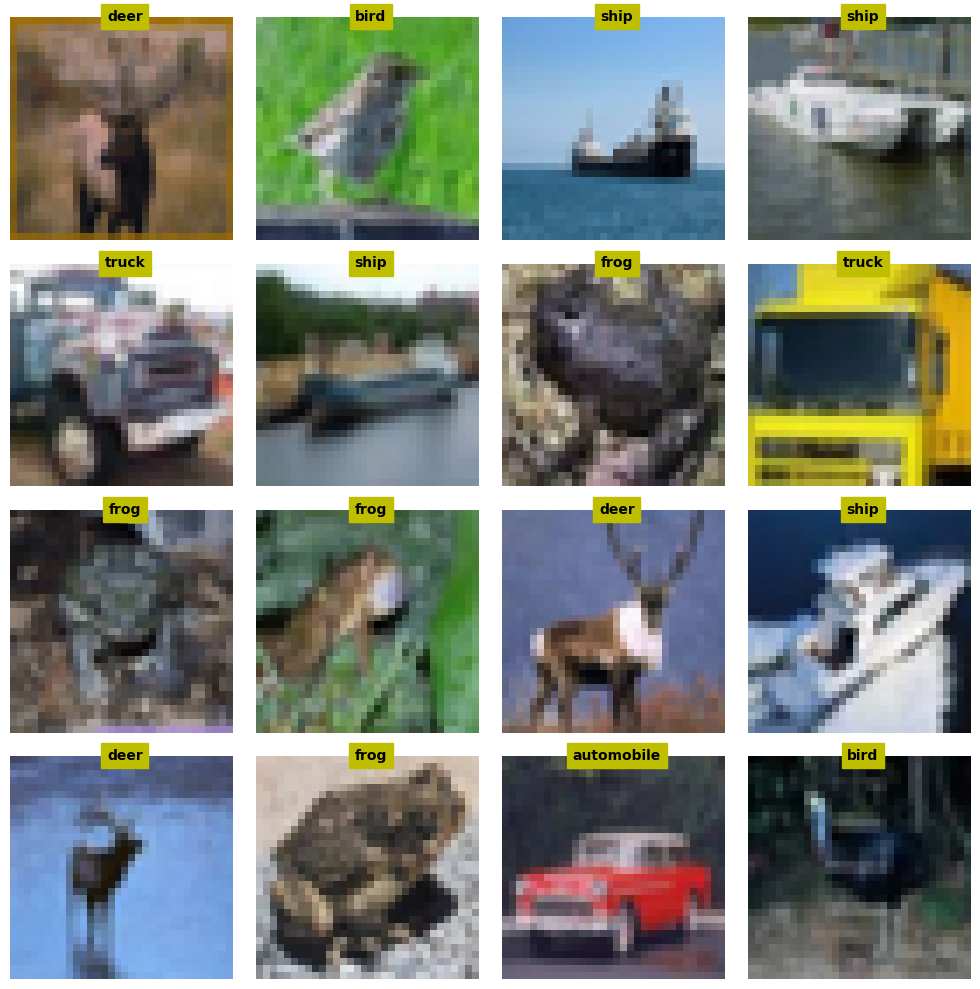

In [6]:
# inspect a few random images

fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 32x32x3)
  pic = X.data[i].numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization

  # and its label
  label = trainset.classes[y[i]]

  # and show!
  ax.imshow(pic)
  ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

# Create DL model

In [7]:
# Helper functions

def _as_list(value, n: int):
    """Normalize a scalar/tuple/sequence into a list of length n.
       - If value is a scalar or tuple, replicate it n times.
       - If value is a sequence of length 1, replicate it n times.
       - If value is a sequence of length n, use as is.
    """

    # tuples are valid for kernel/stride/padding/dilation
    if isinstance(value, (int, float, tuple)):
        return [value for _ in range(n)]
    if isinstance(value, Sequence):
        if len(value) == 1 and n > 1:
            return [value[0] for _ in range(n)]
        if len(value) == n:
            return list(value)
    raise ValueError(f"Could not broadcast parameter to length {n}: {value}")

In [8]:
# create a class for the model

def makeTheNet(out_channels: Sequence[int] = [6,6],         #conv1, conv2
                kernel_size: int | Tuple[int, int]=3,
                stride: int | Tuple[int, int]=1,
                padding: Optional[int | Tuple[int, int]]=[1,0],
                pool_size: Optional[Tuple[int, int]]=(2,2),
                dilation: int | Tuple[int, int]=1,
                groups: int =1,
                bias: bool =True,
                padding_mode: str='zeros',
                cv_dropout: float = 0.0,
                cv_batchnorm: bool = False,

                # Defintions for the FC layer
                uLinear: Optional[Sequence[int]] = [50],
                ln_batchnorm: bool = False,
                out_size: int = 26,
                ln_dropout: float = 0.0,

                # Regularization
                optimizer = 'Adam',
                weight_decay: float = 0.0,
                lr: float = 1e-3,

                device=None,
                dtype=None,
                printtoggle: bool = False):

  class emnistnet(nn.Module):
    def __init__(self,
                out_channels: Sequence[int] = out_channels,     #conv1, conv2
                kernel_size: int | Tuple[int, int]=kernel_size,
                stride: int | Tuple[int, int]=stride,
                padding: Optional[int | Tuple[int, int]]=padding,
                pool_size: Optional[Tuple[int, int]]=pool_size,
                dilation: int | Tuple[int, int]=dilation,
                groups: int =groups,
                bias: bool = bias,
                padding_mode: str=padding_mode,
                cv_dropout: float = cv_dropout,
                cv_batchnorm: bool = cv_batchnorm,

                # Defintions for the FC layer
                uLinear: Optional[Sequence[int]] = uLinear,
                ln_batchnorm: bool = ln_batchnorm,
                out_size: int = out_size,
                ln_dropout: float = ln_dropout,
                device=device,
                dtype=dtype,
                printtoggle: bool = printtoggle
                ):
      super().__init__()

      # right at the start of __init__ or before building convs
      # assert isinstance(in_channels, int) and in_channels > 0, f"in_channels must be > 0, got {in_channels}"
      for i, oc in enumerate(out_channels):
          assert int(oc) > 0, f"out_channels[{i}] must be > 0, got {oc}"


      # print toggle
      self.printtoggle = printtoggle

      self.pool = nn.MaxPool2d(pool_size)

      self.cv_batchnorm = cv_batchnorm
      self.ln_batchnorm = ln_batchnorm


      nBlocks = len(out_channels)               # number of conv blocks

      # Normalize per-block parameters
      k_list = _as_list(kernel_size, nBlocks)
      s_list = _as_list(stride,      nBlocks)
      p_list = _as_list(padding,     nBlocks)
      d_list = _as_list(dilation,    nBlocks)
      pool_list = _as_list(pool_size, nBlocks)

      #--------Build Convoluation Blocks----------
      convs = []
      cbns = []                 # Batch normalization for each layer
      pools = []
      cdo = []                 # Dropout per convolution block (optional)


      # prev_c = in_channels

      # ---- Convolutional stack ----
      for i in range(nBlocks):
        convs.append(nn.LazyConv2d(
        out_channels=out_channels[i],
        kernel_size=k_list[i],
        stride=s_list[i],
        padding=p_list[i],
        dilation=d_list[i],
        groups=groups,
        bias=bias,
        padding_mode=padding_mode
    ))

        if self.cv_batchnorm:
          cbns.append(nn.BatchNorm2d(out_channels[i]))
        else:
          cbns.append(nn.Identity())

        pools.append(nn.MaxPool2d(kernel_size=pool_list[i]))

        if cv_dropout > 0:
          cdo.append(nn.Dropout2d(cv_dropout))
        else:
          cdo.append(nn.Identity())

        # prev_c = out_channels[i]

      self.convs = nn.ModuleList(convs)
      self.cbns  = nn.ModuleList(cbns)
      self.pools = nn.ModuleList(pools)
      self.cdo   = nn.ModuleList(cdo)

      # Safety checks (helps catch the “zip returns nothing” bug)
      assert len(self.convs) > 0, "No conv blocks built"
      assert len(self.convs) == len(self.pools) == len(self.cbns) == len(self.cdo), (len(self.convs), len(self.pools), len(self.cbns), len(self.cdo))

      # --- Linear stack/ Multi-Layer Perceptorn (MLP) (variable depth) ---
      sizes = list(uLinear) if uLinear is not None else [50]
      fcs, fbns, fdo = [], [], []

      # in_f = flat

      for h in sizes:
          fcs.append(nn.LazyLinear(h))
          if self.ln_batchnorm:
            fbns.append(nn.BatchNorm1d(h))
          else:
            fbns.append(nn.Identity())

          if ln_dropout > 0:
              fdo.append(nn.Dropout(ln_dropout))
          else:
              fdo.append(nn.Identity())

          # in_f = h


      self.fcs  = nn.ModuleList(fcs)
      self.fbns = nn.ModuleList(fbns)
      self.fdo  = nn.ModuleList(fdo)
      self.output_layer = nn.LazyLinear(out_size)

    def forward(self,x):

      if self.printtoggle: print(f'Input: {list(x.shape)}')

      # Convolutional stack: Conv -> (BN) -> Max_Pool -> LeakyReLU -> (Dropout2d)
      for i in range(len(self.convs)):

        x = self.convs[i](x)
        x = self.cbns[i](x)
        x = self.pools[i](x)
        x = F.leaky_relu(x, inplace=True)
        x = self.cdo[i](x)

        if self.printtoggle: print(f'After block {i+1}: {list(x.shape)}')
        if self.printtoggle: print(f'Block {i+1} padding {self.convs[i].padding}')

      # reshape for linear layer
      x = torch.flatten(x,start_dim=1)
      if self.printtoggle: print(f'Vectorized: {list(x.shape)}')

      ## FC stack
      for i in range(len(self.fcs)):

        x = self.fcs[i](x)
        x = self.fbns[i](x)
        x = F.leaky_relu(x, inplace=True)
        x = self.fdo[i](x)

        if self.printtoggle: print(f'After FC {i+1}: {list(x.shape)}')


      x = self.output_layer(x)

      return x

  #-------------------End of model factory------------------------------

  # create the model instance
  net = emnistnet()

  # Move to device/dtype once (constructor kwargs are version-fragile)
  if device is not None or dtype is not None:
      net = net.to(device=device, dtype=dtype)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = getattr(torch.optim,optimizer)(net.parameters(),lr=lr,weight_decay=weight_decay)

  return net,lossfun,optimizer

In [9]:
# test the model with one batch
out_channels = [64,128,256]
uLinear = [256,64]
paddings = [1,0,0]
out_size = len(trainset.classes)
printtoggle = True

net,lossfun,optimizer = makeTheNet(out_size = out_size,
                                   out_channels = out_channels,
                                   uLinear = uLinear,
                                   padding = paddings,
                                   printtoggle=printtoggle
                                )

X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)

Input: [1024, 3, 32, 32]
After block 1: [1024, 64, 16, 16]
Block 1 padding (1, 1)
After block 2: [1024, 128, 7, 7]
Block 2 padding (0, 0)
After block 3: [1024, 256, 2, 2]
Block 3 padding (0, 0)
Vectorized: [1024, 1024]
After FC 1: [1024, 256]
After FC 2: [1024, 64]

Output size:
torch.Size([1024, 10])
 
Loss:
tensor(2.3069, grad_fn=<NllLossBackward0>)


# Create a Function to train the model

In [16]:
def function2trainTheModel(
    numepochs: int,
    out_channels: list[int] = [6, 6],
    kernel_size: int | tuple[int, int] = 3,
    stride: int | tuple[int, int] = 1,
    padding: int | tuple[int, int] | list[tuple[int, int]] = [1, 0, 0],
    pool_size: tuple[int, int] = (2, 2),
    dilation: int | tuple[int, int] = 1,
    groups: int = 1,
    bias: bool = True,
    padding_mode: str = "zeros",
    cv_dropout: float = 0.0,
    cv_batchnorm: bool = False,
    uLinear: list[int] = [50],
    ln_batchnorm: bool = False,
    out_size: int = 26,
    ln_dropout: float = 0.0,
    optimizer: str = "Adam",          # name of optimizer (Adam, AdamW, SGD, ...)
    weight_decay: float = 0.0,
    lr: float = 1e-3,
    device: torch.device | None = None,
    dtype=None,
    printtoggle: bool = False,
):
    # ---------- Device selection (don’t rely on outer globals) ----------
    if device is None:
        if torch.cuda.is_available():
            device = torch.device("cuda")
        elif torch.backends.mps.is_available():
            device = torch.device("mps")
        else:
            device = torch.device("cpu")
    print("Using device:", device)

    opt_name = optimizer
    net, lossfun, opt = makeTheNet(
        out_channels=out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=padding,
        pool_size=pool_size,
        dilation=dilation,
        groups=groups,
        bias=bias,
        padding_mode=padding_mode,
        cv_dropout=cv_dropout,
        cv_batchnorm=cv_batchnorm,
        uLinear=uLinear,
        ln_batchnorm=ln_batchnorm,
        out_size=out_size,
        ln_dropout=ln_dropout,
        optimizer=opt_name,
        weight_decay=weight_decay,
        lr=lr,
        device=device,   # safely pass device through
        dtype=dtype,
        printtoggle=printtoggle,
    )

    net.to(device)
    lossfun = lossfun.to(device)

    # ---------- AMP (new API); enable only on CUDA ----------
    use_cuda = (device.type == "cuda")
    scaler = torch.amp.GradScaler(enabled=use_cuda)
    autocast_ctx = torch.autocast(device_type="cuda",dtype=torch.float16, enabled=use_cuda)

    # ---------- Metrics (avoid per-batch .item() → sync once/epoch) ----------
    trainLoss = torch.zeros(numepochs)
    testLoss  = torch.zeros(numepochs)
    trainErr  = torch.zeros(numepochs)
    testErr   = torch.zeros(numepochs)

    net.train()
    # ---------- Epoch loop ----------
    # for epochi in tqdm(range(numepochs), desc="Epoch", total=numepochs):
    for epochi in range(numepochs):
        # ---------- Batch loop ----------
        batch_loss_sum = torch.zeros((), device=device)
        err_count = torch.zeros((), device=device, dtype=torch.long)
        n_seen = 0

        # for X, y in tqdm(train_loader, desc="Batch", total=len(train_loader.dataset.data)/batch_size,leave=False):
        for X, y in train_loader:
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            opt.zero_grad(set_to_none=True)

            with autocast_ctx:
                yHat = net(X)
                loss = lossfun(yHat, y)

            if use_cuda:
                scaler.scale(loss).backward()
                scaler.step(opt)
                scaler.update()
            else:
                loss.backward()
                opt.step()

            # accumulate on device (no CPU sync)
            with torch.no_grad():
                batch_loss_sum += loss.detach() * y.size(0)
                err_count += (yHat.argmax(dim=1) != y).sum()
                n_seen += y.size(0)

        # end train epoch: sync once
        trainLoss[epochi] = (batch_loss_sum / max(n_seen, 1)).detach().cpu()
        trainErr[epochi]  = (100.0 * err_count.float() / max(n_seen, 1)).detach().cpu()

        # ---------- Evaluation on full test loader (not a single batch) ----------
        net.eval()
        test_loss_sum = torch.zeros((), device=device)
        test_err_count = torch.zeros((), device=device, dtype=torch.long)
        test_seen = 0

        with torch.no_grad():
            for X, y in dev_loader:
                X = X.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
                yHat = net(X)
                test_loss_sum += lossfun(yHat, y) * y.size(0)
                test_err_count += (yHat.argmax(dim=1) != y).sum()
                test_seen += y.size(0)

        testLoss[epochi] = (test_loss_sum / max(test_seen, 1)).detach().cpu()
        testErr[epochi]  = (100.0 * test_err_count.float() / max(test_seen, 1)).detach().cpu()

    # done
    return trainLoss, testLoss, trainErr, testErr, net


# Run the model

In [25]:
# test the model with one batch
out_channels = [64,128,256]
uLinear = [256,64]
paddings = [1,0,0]
out_size = len(trainset.classes)
printtoggle = False

trainLoss,devLoss,trainErr, devErr,net = function2trainTheModel(
    numepochs = 50,
    out_size = out_size,
    out_channels = out_channels,
    uLinear = uLinear,
    padding = paddings,
    printtoggle=printtoggle
)
trainloss = torch.mean(trainLoss).numpy()
devloss = torch.mean(devLoss).numpy()

trainerr = torch.mean(trainErr).numpy()
deverr = torch.mean(devErr).numpy()

print('Train Loss:', trainloss)
print('Dev Loss:', devloss)
print('Train Err:', trainerr)
print('Dev Err:', deverr)

Using device: cuda
Train Loss: 0.41888335
Dev Loss: 1.3890839
Train Err: 14.67204
Dev Err: 30.121332


# test the real tesetset

In [26]:
net.eval()
test_batchloss = []
test_batcherr = []
for X,y in test_loader:
  X = X.to(device)
  y = y.to(device)

  with torch.no_grad():
    yHat = net(X)
    loss = lossfun(yHat, y)

    #---Move back yHat, loss, y to CPU
    yHat = yHat.cpu()
    loss = loss.cpu()
    y = y.cpu()

    test_batchloss.append(loss.detach().numpy())
    test_batcherr.append( torch.mean((torch.argmax(yHat,axis=1) != y).float()).detach().numpy())

#Loss and accuracy for the batch
testloss = np.mean(test_batchloss)
testerr = 100 * np.mean(test_batcherr)

print(f'Test loss: {testloss}')
print(f'Test Error: {testerr}')

Test loss: 2.004408359527588
Test Error: 25.72063446044922


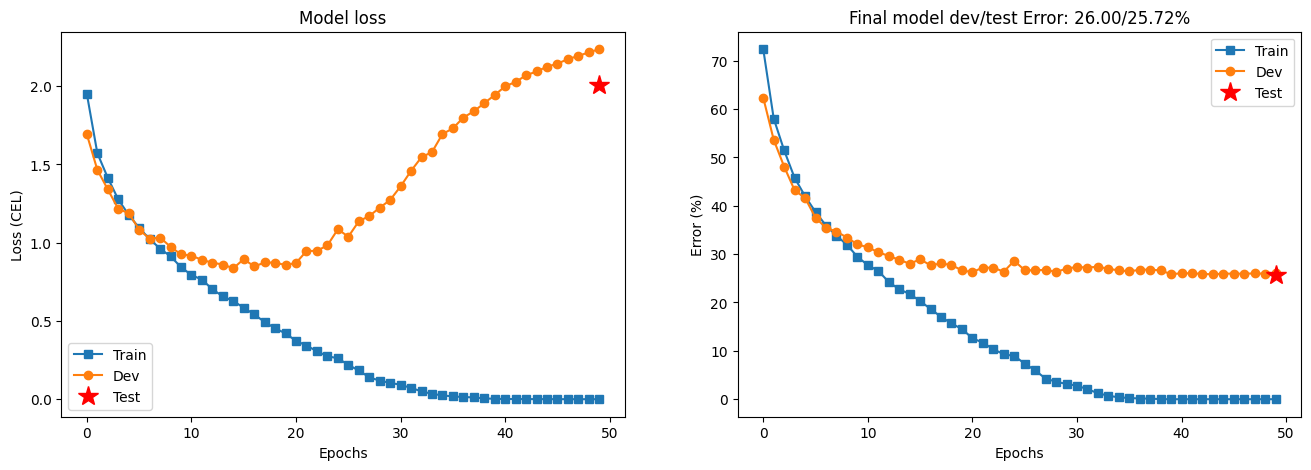

In [27]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(devLoss,'o-',label='Dev')
ax[0].plot(len(devLoss)-1,testloss,'r*',markersize=15,label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainErr,'s-',label='Train')
ax[1].plot(devErr,'o-',label='Dev')
ax[1].plot(len(devErr)-1,testerr,'r*',markersize=15,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error (%)')
ax[1].set_title(f'Final model dev/test Error: {devErr[-1]:.2f}/{testerr:.2f}%')
ax[1].legend()

plt.show();

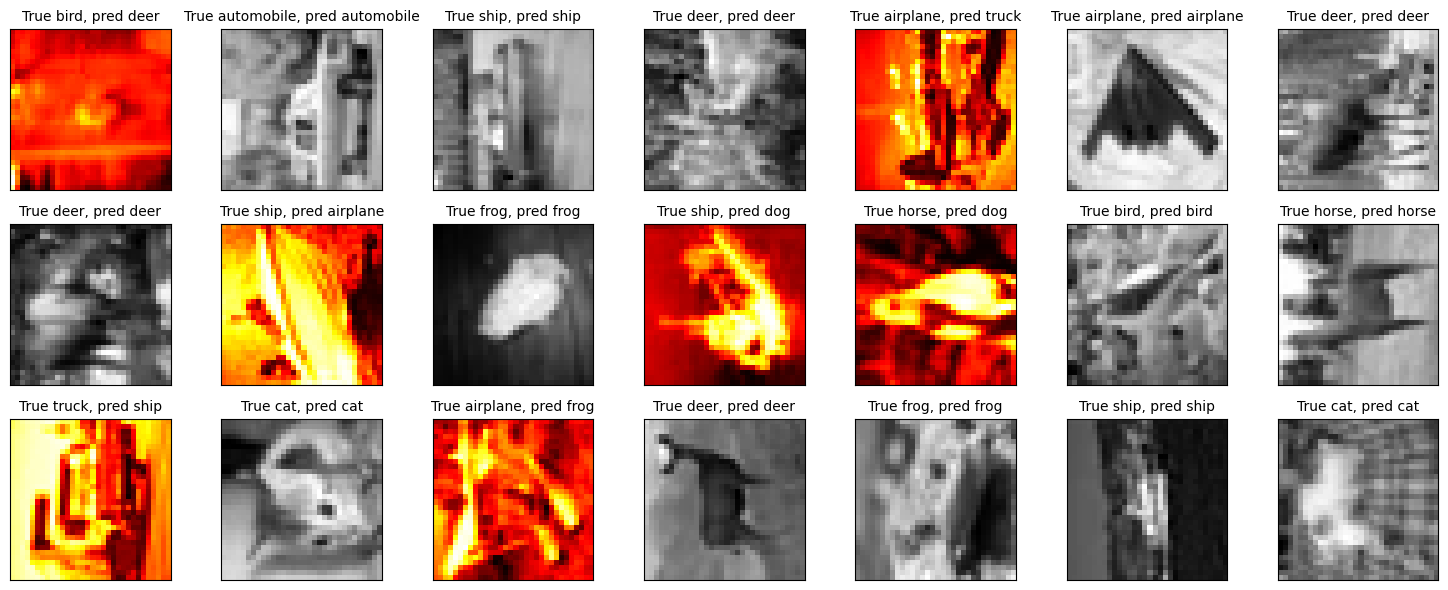

In [28]:
### visualize some images
imageClasses = testset.dataset.classes

# extract X,y from test dataloader
X,y = next(iter(test_loader))
X = X.to(device) # push data to GPU
y = y.to(device) # push data to GPU

# Ensure the model is on the correct device
net = net.to(device)

yHat = net(X)

# pick some examples at random to show
randex = np.random.choice(len(y),size=21,replace=False)

# visualize some images
fig,axs = plt.subplots(3,7,figsize=(15,6))

for i,ax in enumerate(axs.flatten()):

  # extract the image and its target letter
  I = np.squeeze( X[randex[i],0,:,:] ).cpu() # .cpu() to transfer back from GPU!
  trueImage = imageClasses[ y[randex[i]] ]
  predImage = imageClasses[ torch.argmax(yHat[randex[i],:]) ]

  # color-code the accuracy (using ternary operator)
  col = 'gray' if trueImage==predImage else 'hot'

  # visualize
  ax.imshow(I.T,cmap=col)
  ax.set_title('True %s, pred %s' %(trueImage,predImage),fontsize=10)
  ax.set_xticks([])
  ax.set_yticks([])
plt.tight_layout()
plt.show()